In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import jax
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt

from otf import optim
from otf import time_integration as ti
from otf.asyncd import utils
from otf.system import System_ModelKnown

from plot import plot

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values():
    # Initial true state
    u0 = jnp.array([-2, 0], dtype=float)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return u0, un0

In [ ]:
def true_ode(gs: jndarray, true: jndarray) -> jndarray:
    a, b, c, d = gs

    x, y = true

    return jnp.array([a * y, -b * x + c * y * jnp.cos(d * x)])


def assimilated_ode(cs: jndarray, nudged: jndarray) -> jndarray:
    a, b, c, d = cs

    x, y = nudged

    return jnp.array([a * y, -b * x + c * y * jnp.cos(d * x)])


# System evolution parameters
gs = a, b, c, d = 1, 1, 0.1, 0.75
gs = jnp.array(gs)
c1, c2, c3, c4 = gs
c1 *= 1.4
c2 *= 0.6
c3 *= 1.4
c4 *= 1.4
cs = jnp.array([c1, c2, c3, c4])

mu = 10

true0, assimilated0 = get_initial_values()

observed_mask = jnp.array([1, 1], dtype=bool)
system = System_ModelKnown(mu, gs, cs, observed_mask, assimilated_ode, true_ode)

solver = ti.ForwardEuler(system)
solver = ti.TwoStepAdamsBashforth(system, solver)

# Simulation parameters
dt = 0.01
T0, Tf = 0, 400
t_relax = 1

gradient_computer = optim.gradient.AdjointGradient(
    system,
    dt,
    optim.gradient.adjoint.UpdateOption.complete,
    (ti.ForwardEuler, ti.TwoStepAdamsBashforth),
)
optimizer = optax.adam(1e-2)
optimizer = optim.OptaxWrapper(system, optimizer, gradient_computer)

true_solver = solver
trues, tls_ = true_solver.solve_true(true0, T0, Tf, dt)

true_observed = trues[:, system.observed_mask]

cs, u_errors, tls, assimilateds = utils.run_update(
    system,
    true_observed,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    assimilated0,
    optimizer=optimizer,
    return_all=True,
)
tls_all = np.arange(len(trues)) * dt

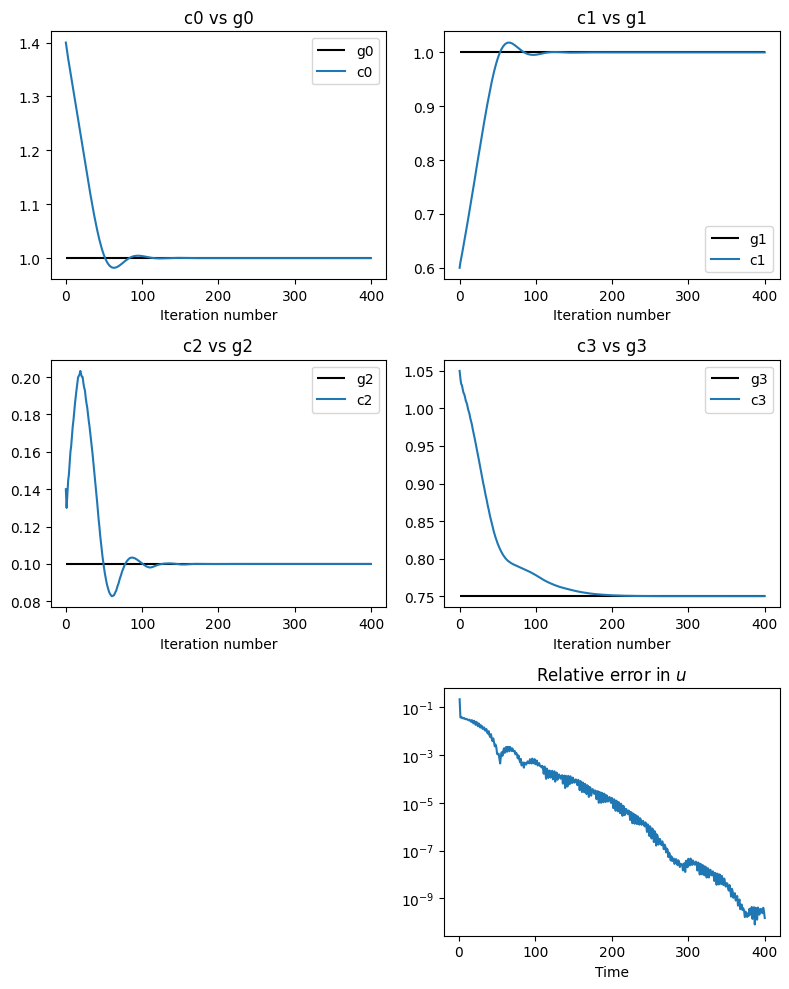

In [ ]:
fig, axs = plot(cs, u_errors, gs, tls)
fig.set_size_inches(8, 10)
fig.tight_layout()
plt.show()

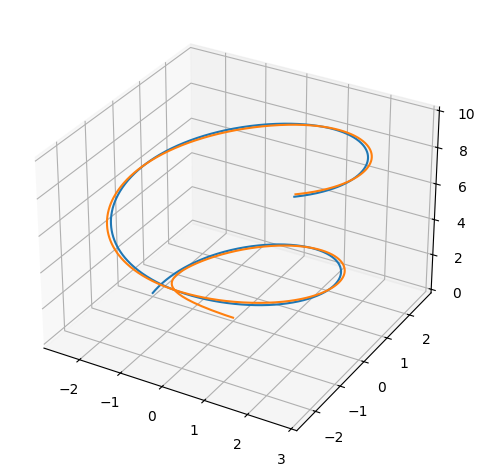

In [ ]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"})

s_ = np.s_[15000:20000]
s_ = np.s_[:1000]
ax.plot(*trues[s_].T, tls_all[s_])
ax.plot(*assimilateds[s_].T, tls_all[s_])

fig.tight_layout()
plt.show()